# **Transfer Learning with RESNET 18**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**

* STL-10 Dataset (STL: Stanford, Toronto, and Leipzig)
    * Image dataset containing images of size 96x96 pixels
    * Consists of 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, and truck
    * Total of 5,000 labeled images for training and 8,000 labeled images for testing
    * Each class has 500 training images and 800 testing images
    * Additionally includes an unlabeled dataset of 100,000 images
    * Commonly used for unsupervised learning, semi-supervised learning, and transfer learning tasks
    * Images collected from labeled datasets from ImageNet and manually annotated
    * Freely available for research purposes

_________________________
**Accessing Dataset**

In [1]:
cd ..

/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/advanced_deep_learning


In [2]:
cd datasets

/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/advanced_deep_learning/datasets


___________

In [3]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import summary libraries for model information
from torchsummary import summary

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# import torchvision and transformations libraries
import torchvision as tv
import torchvision.transforms as T

In [4]:
# use if GPU is available 
device = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
# Import a dataset

### Note that resnet is trained for images in a specific range of pixel values not [-1,1]

# transformations
transform=T.Compose([ 
    T.ToTensor(), # normalizes the image to range [0,1]
    T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ]
)

# import the data and simultaneously apply the transform
trainset=tv.datasets.STL10(root='./stl10',download=True,split='train',transform=transform)
testset=tv.datasets.STL10(root='./stl10',download=True,split='test',transform=transform)

# step 4: translate into dataloader objects
batchsize=32
train_loader=DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(testset,batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# check out the shape of the datasets
print("Data shapes (train/test):")
print(f"{trainset.data.shape}")
print(f"{testset.data.shape}")

# and average the range of pixel intensity values
print('\nData value range')
print((np.min(trainset.data),np.max(trainset.data)))

# print the unique categories
print('\nData categories')
print(trainset.classes)

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range
(0, 255)

Data categories
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [7]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 3x96x96
# and they are not normalized 

# but ..
X,y=next(iter(train_loader))

# try again 
print("Data shapes (train/test):")
print(f"{X.data.shape}")

# and average the range of pixel intensity values
print('\nData value range')
print((tr.min(X.data),tr.max(X.data)))

Data shapes (train/test):
torch.Size([32, 3, 96, 96])

Data value range
(tensor(-2.1179), tensor(2.6400))


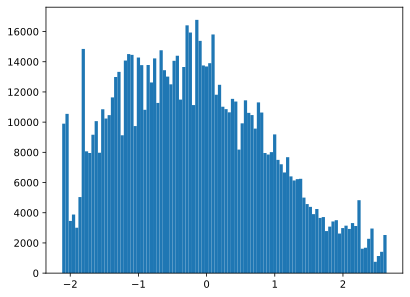

In [8]:
# histogram of the data 
plt.hist(X.data.numpy().flatten(),100);  

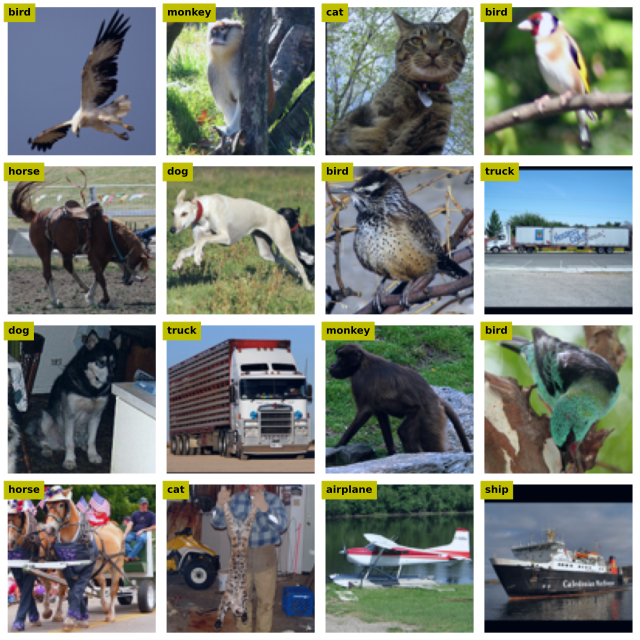

In [9]:
# inspect a few random images 
fig,axs=plt.subplots(4,4,figsize=(9,9))

for (i,ax) in enumerate(axs.flatten()):
  # extract the image (need to transpose it back to 96x96x3)
  pic=X.data[i].numpy().transpose((1,2,0))
  pic=(pic-np.min(pic))/(np.max(pic)-np.min(pic))

  # and its label
  label=trainset.classes[y[i]]

  # and show
  ax.imshow(pic)
  ax.text(0,0,label,ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# import and inspect the resnet model
from torchvision.models import resnet18, ResNet18_Weights
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)

In [11]:
# lets inspect the network
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
summary(resnet.to(device),(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [13]:
# freeze all layers (final layer changed later)
for p in resnet.parameters():
    p.requires_grad=False

    # python note: the above operation can be implemented in-line
    # p.requires_grad_(False)

In [14]:
# change the final layer
resnet.fc=nn.Linear(512,10)

In [15]:
# push the model to the GPU (if using)
resnet.to(device);

In [16]:
# Train the model
lossfun=nn.CrossEntropyLoss()
optimizer=tr.optim.SGD(resnet.parameters(),lr=0.01,momentum=0.9)

In [18]:
numepochs=10

# initialize losses
trainLoss=tr.zeros(numepochs)
testLoss=tr.zeros(numepochs)
trainAcc=tr.zeros(numepochs)
testAcc=tr.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over the training data batches 
    resnet.train()  # switch to train mode
    batchLoss=[]
    batchAcc=[]

    for X,y in train_loader:

        # push data to GPU
        X=X.to(device)
        y=y.to(device)

        # forward pass and loss
        yHat=resnet(X)
        loss=lossfun(yHat,y)

        # backprop  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch 
        batchLoss.append(loss.item())
        batchAcc.append(tr.mean((tr.argmax(yHat,axis=1)==y).float()).item())
        
        # end of batch loop

    # and get the average losses and accuracies across the batches
    trainLoss[epochi]=np.mean(batchLoss)
    trainAcc[epochi]=100*np.mean(batchAcc)

    ### test performance (here done in batches)
    resnet.eval() # switch to test mode
    batchAcc=[]
    batchLoss=[]
    for X,y in test_loader:
        # push the data to GPU
        X=X.to(device)
        y=y.to(device)

        # forward pass and loss
        with tr.no_grad():
            yHat=resnet(X)
            loss=lossfun(yHat,y)

        # loss and accuracy from this batch 
        batchLoss.append(loss.item())
        batchAcc.append(tr.mean((tr.argmax(yHat,axis=1)==y).float()).item())
    # end of batch loop
        
    # and get the average losses and accuracies across the batches
    testLoss[epochi]=np.mean(batchLoss)
    testAcc[epochi]=100*np.mean(batchAcc)

    print(f'{epochi+1}/{numepochs} completed!!!. Test Accuracy={testAcc[epochi]:.2f}%')

1/10 completed!!!. Test Accuracy=74.52%
2/10 completed!!!. Test Accuracy=76.71%
3/10 completed!!!. Test Accuracy=75.81%
4/10 completed!!!. Test Accuracy=74.67%
5/10 completed!!!. Test Accuracy=77.09%
6/10 completed!!!. Test Accuracy=73.84%
7/10 completed!!!. Test Accuracy=74.80%
8/10 completed!!!. Test Accuracy=74.44%
9/10 completed!!!. Test Accuracy=76.12%
10/10 completed!!!. Test Accuracy=74.83%


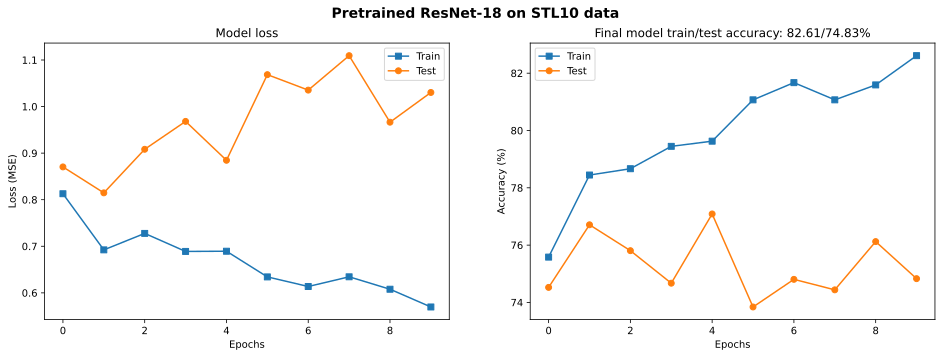

In [20]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

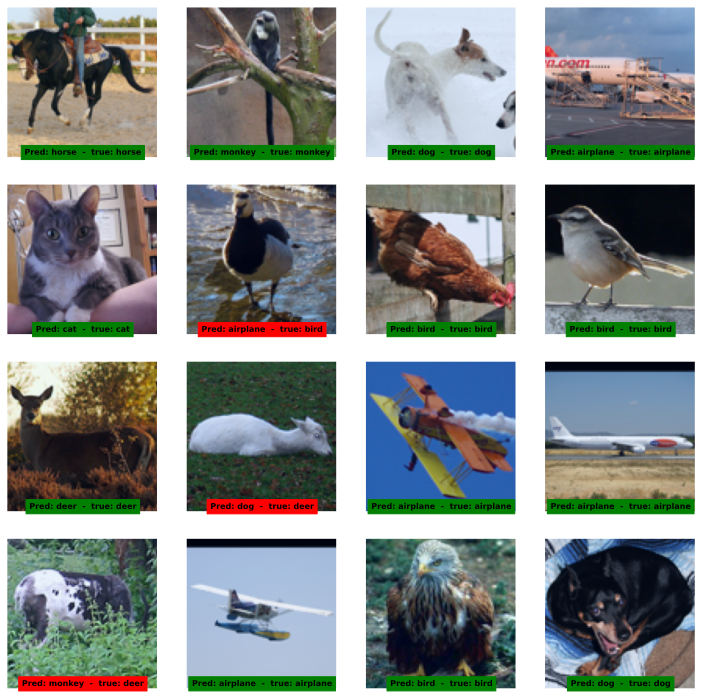

In [19]:
# inspect a few random images

X,y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
resnet.eval()
predictions = tr.argmax( resnet(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image (need to transpose it back to 96x96x3)
  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)
  
  # show the image
  ax.imshow(pic)
  
  
  # label and true class
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(48,90,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

**Additional Explorations**

In [ ]:
# 1) Try re-downloading the resnet18, unfreeze the layers, and re-run. This means you'll be fine-tuning the entire network instead of only the final prediction layer.

# 2) Download an untrained resnet18. This is simply the architecture with random weights (you'll still need to replace the final layer so it has 10 outputs). Train this model; how is the performance?

# 3) I used SGD as the backprop method. Try re-running the analysis using Adam. Does this help or hurt the train and test performance?

# 4) ~80% accuracy is pretty decent considering we didn't do anything to optimize the model. Looking through the model metaparameters, what are some things you would try to change if you wanted to boost performance?

# 5) You've seen earlier in the course that data normalization is important. This is particularly so for pretrained networks, because the weights are tuned to specific numerical ranges. But how important is the *exact* numerical range? To find out, re-run the code but remove the normalization transform. Thus, the images now will be in the range [0,1], which is overlapping with but smaller than (and non-negative) the range that the network is trained on.